In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [3]:
import numpy as np
from stm.models.abstract import Model

# bayesian linear regression

class BayesLinRegr(Model):
    
    def __init__(self, kelly_std:float = 2, max_w:float = 1, bias_reduction:float = 0, m2:bool = True):
        
        self.kelly_std = kelly_std
        self.max_w = max_w
        self.bias_reduction = bias_reduction
        self.m2 = m2
        assert 0 <= self.bias_reduction <= 1, "bias reduction must be between 0 and 1"
        # parameters
        self.a, self.b, self.m, self.p, self.q = None, None, None, None, None
        
    def view(self, **kwargs):
        print('** LR **')
        print('a: ', self.a)
        print('b: ', self.b)
        print('m: ', self.m)
        print('q: ', self.q)
        print('p: ', self.p)
        print('w_norm: ', self.w_norm)
        
    def _linreg(self, X, y):
        '''
        Linear regression from X (matrix) to y (vector)
        '''
        return np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
               
    def estimate(self, y, x, **kwargs):
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must be a vector"
        if x.ndim == 2:
            assert x.shape[1] == 1, "x must be a vector"
        y = y[:,0]
        x = x[:,0]
        # add intercept
        X = np.hstack((np.ones((x.size,1)),x[:,None]))
        # make the regression
        c = self._linreg(X, y)
        # compute model parameters
        self.a, self.b = c[0], c[1]
        self.p = np.var(y)
        self.m = np.mean(x)
        self.q = np.var(x)
        self.w_norm = self.kelly_std * np.abs(self.b)*np.sqrt(self.q) / self.p
        # self.view()

    def get_weight(self, xq, **kwargs):
                
        if self.m2:
            w = (self.a+self.b*xq)/(self.p+np.power(self.a+self.b*xq,2)) - self.bias_reduction*(self.a+self.b*self.m)/(self.p+self.b*self.b*self.q+np.power(self.a+self.b*xq,2))
        else:
            w = ( self.a * (1 - self.bias_reduction) + self.b * (xq - self.bias_reduction*self.m)) / self.p
        #if self.unbiased:
        #   w = self.b * (xq-self.m) / self.p
        #else:
        #   w = (self.a + self.b * xq) / self.p
        w /= self.w_norm
        d = np.abs(w)
        if d > self.max_w:
            w /= d
            w *= self.max_w
        return w





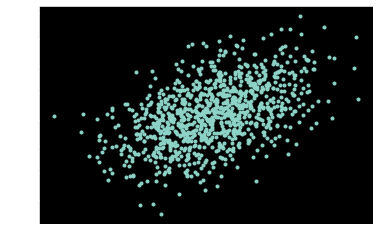

In [7]:
# generate data
n = 1000
a = 0.1
b = 0.25
scale = 0.5
x = np.random.normal(0, 1, n)
y = a + b*x + np.random.normal(0, scale, n)
plt.plot(x, y, '.')
plt.show()